# Improved Clustering

## Load Data:

In [1]:
import pickle

df_covid = pickle.load(open("plot_data/df_covid_new.p", "rb"))
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26043 entries, 0 to 27677
Data columns (total 13 columns):
paper_id               26043 non-null object
abstract               26043 non-null object
body_text              26043 non-null object
authors                26043 non-null object
title                  26043 non-null object
journal                26043 non-null object
abstract_summary       26043 non-null object
abstract_word_count    26043 non-null int64
body_word_count        26043 non-null int64
body_text_clean        26043 non-null object
abstract_clean         26043 non-null object
processed_text         26043 non-null object
language               26043 non-null object
dtypes: int64(2), object(11)
memory usage: 2.8+ MB


Get the English articles only.

In [2]:
df_covid = df_covid.loc[df_covid['language'] == 'en']

In [3]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24934 entries, 0 to 27677
Data columns (total 13 columns):
paper_id               24934 non-null object
abstract               24934 non-null object
body_text              24934 non-null object
authors                24934 non-null object
title                  24934 non-null object
journal                24934 non-null object
abstract_summary       24934 non-null object
abstract_word_count    24934 non-null int64
body_word_count        24934 non-null int64
body_text_clean        24934 non-null object
abstract_clean         24934 non-null object
processed_text         24934 non-null object
language               24934 non-null object
dtypes: int64(2), object(11)
memory usage: 2.7+ MB


## Vectorize

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2**10)
X = vectorizer.fit_transform(df_covid['processed_text'].values)

In [41]:
X.shape

(24934, 1024)

## PCA

Let's see how much we can reduce the dimensions while still keeping 95% variance.

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(24934, 647)

## Get the Labels for the Plot

### k-means

In [44]:
from sklearn.cluster import MiniBatchKMeans

k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_reduced)

## t-SNE

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24934 samples in 4.618s...
[t-SNE] Computed neighbors for 24934 samples in 1167.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24934
[t-SNE] Computed conditional probabilities for sample 2000 / 24934
[t-SNE] Computed conditional probabilities for sample 3000 / 24934
[t-SNE] Computed conditional probabilities for sample 4000 / 24934
[t-SNE] Computed conditional probabilities for sample 5000 / 24934
[t-SNE] Computed conditional probabilities for sample 6000 / 24934
[t-SNE] Computed conditional probabilities for sample 7000 / 24934
[t-SNE] Computed conditional probabilities for sample 8000 / 24934
[t-SNE] Computed conditional probabilities for sample 9000 / 24934
[t-SNE] Computed conditional probabilities for sample 10000 / 24934
[t-SNE] Computed conditional probabilities for sample 11000 / 24934
[t-SNE] Computed conditional probabilities for sample 12000 / 24934
[t-SNE] Computed conditional probabilities for

## Save

In [51]:
import pickle

# save the final t-SNE
pickle.dump(X_embedded, open("plot_data/X_embedded_new.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("plot_data/y_pred_new.p", "wb" ))

## Plot

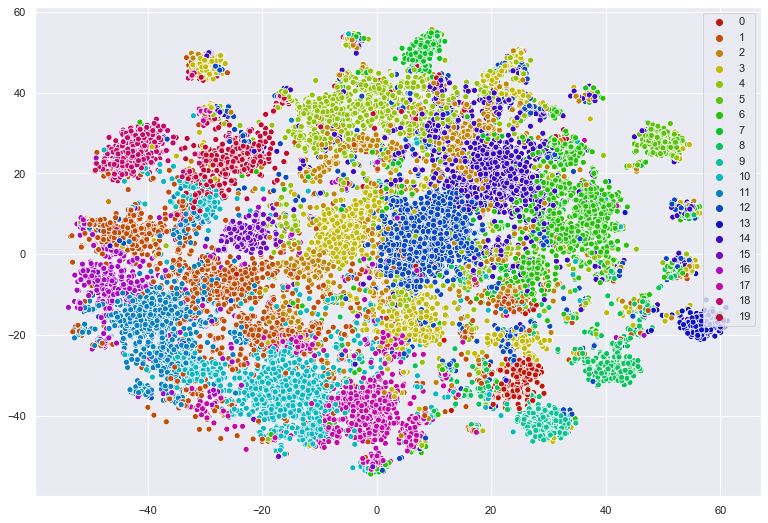

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.savefig("plots/improved_cluster_tsne.png")
plt.show()

## Classify
### Random Forest

In [15]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [7]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 19947
X_test size: 4987 



In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  79.415 %


In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred, average='macro')) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(recall_score(y_train, forest_train_pred, average='macro')) * 100), "%")

Precision:  86.501 %
   Recall:  71.250 %


In [10]:
# first train the model
forest_clf.fit(X_train, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test)

In [16]:
# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  80.529 %
     Precision:  87.209 %
        Recall:  73.616 %
      F1 score:  77.735 %


### K-Neighbors

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knnc = KNeighborsClassifier(weights='distance', n_neighbors=4, n_jobs=4)
knnc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=4, p=2,
                     weights='distance')

In [19]:
# make predictions on the test set
knn_pred = knnc.predict(X_test)
# print out the classification report
classification_report("K-Neighbors Classifier Report (Test Set)", y_test, knn_pred)

K-Neighbors Classifier Report (Test Set) :

Accuracy Score:  79.447 %
     Precision:  81.572 %
        Recall:  82.066 %
      F1 score:  81.654 %


### Stochastic Gradient Descent

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  91.187 %
     Precision:  91.855 %
        Recall:  92.042 %
      F1 score:  91.881 %


In [22]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Test Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Test Set) :

Accuracy Score:  87.327 %
     Precision:  88.478 %
        Recall:  88.025 %
      F1 score:  88.139 %
